In [30]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn scikit-learn opencv-python
%matplotlib inline

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [33]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'
image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
%store -r df


In [34]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [35]:
%%capture
%run imageRead.ipynb

In [36]:
#Ensure df is loaded
print("DataFrame loaded with", len(df), "rows")

DataFrame loaded with 3231 rows


In [37]:
df['image_name'] = df['image_name'].astype(str)
df['image_name'] = df['image_name'].str.replace('\t', '', regex=False)
df['image_name'] = df['image_name'].str.strip()

df['image_path'] = df['image_name'].apply(lambda x: os.path.join(dataset_pth, x))

print("Sample image names and paths:")
print(df[['image_name', 'image_path']].head())

# Find annotations with missing image files
missing = df[~df['image_path'].apply(os.path.exists)]
print("Number of missing image files:", len(missing))

if len(missing) > 0:
    print("Example of missing files:")
    print(missing[['image_name', 'image_path']].head())

df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("After removing missing images, total rows:", len(df))

missing_after = df[~df['image_path'].apply(os.path.exists)]
print("After cleaning, missing files:", len(missing_after))

Sample image names and paths:
   image_name                                         image_path
0  000000.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
1  000001.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2  000002.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
3  000003.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
4  000004.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
Number of missing image files: 316
Example of missing files:
     image_name                                         image_path
2915    136.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2916    145.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2917    235.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2918    236.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2919    237.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
After removing missing images, total rows: 2915
After cleaning, missing files: 0


In [38]:
class DenoiseTransform:
    """
    Apply gentle, edge-preserving denoising using OpenCV fastNlMeansDenoisingColored.
    Input : PIL Image (RGB)
    Output: PIL Image (RGB) after noise reduction
    """
    def __call__(self, img_pil):
        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)

        # OpenCV expects BGR, so convert if needed
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Apply gentle denoising (small h values to avoid over-smoothing)
        denoised_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr,
            None,
            h=6,          # luminance filter strength
            hColor=6,     # color filter strength
            templateWindowSize=7,
            searchWindowSize=21
        )

        # Back to RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)

        # Convert back to PIL
        return Image.fromarray(denoised_rgb)

Image Index 0: 000000.jpg


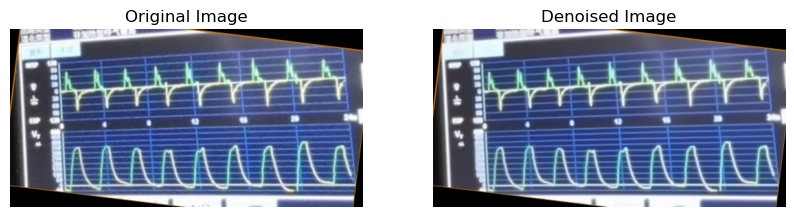

Image Index 3: 000001.jpg


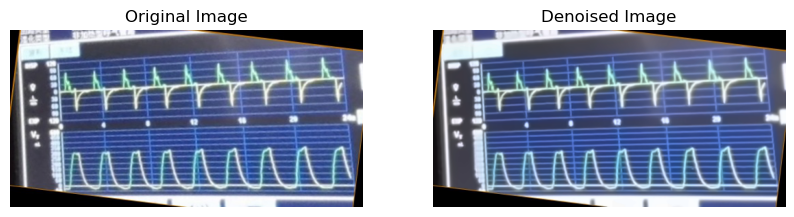

Image Index 6: 000002.jpg


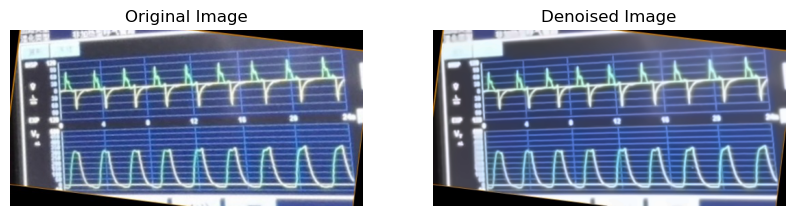

Image Index 9: 000003.jpg


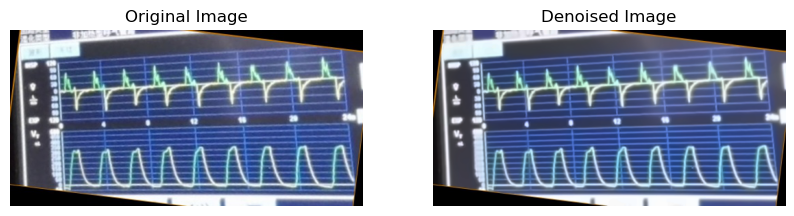

In [39]:

indices = [0, 3, 6, 9]

for idx in indices:
    if idx >= len(image_files):
        print(f"Index {idx} خارج نطاق الصور!")
        continue
    
    image_file = image_files[idx]
    img_path = os.path.join(dataset_pth, image_file)

 
    row = df[df['image_name'] == image_file].iloc[0]

   
    denoise_transform = DenoiseTransform()

    original_img = Image.open(img_path).convert('RGB')
    denoised_img = denoise_transform(original_img)

    print(f"Image Index {idx}: {row['image_name']}")

    plt.figure(figsize=(10, 4))


    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised_img)
    plt.axis('off')

    plt.show()


In [41]:
print("=== NORMALIZATION PIXELS [0,1] ===")

for image_file in image_files[:2]:
    img_path = os.path.join(dataset_pth, image_file)
    image_pil = Image.open(img_path)
    image_array = np.array(image_pil)

    # normalization to [0,1]
    normalized = image_array.astype(np.float32) / 255.0
    print(f"{image_file}:")
    print(f"   Original range: [{image_array.min()}, {image_array.max()}]")
    print(f"   After /255:     [{normalized.min():.3f}, {normalized.max():.3f}]")
    print(f"   First pixel values:")
    print(f"   Original: {image_array[0,0,:]}")
    print(f"   After /255: {normalized[0,0,:]}")
    print()


=== NORMALIZATION PIXELS [0,1] ===
000000.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
   Original: [1 0 4]
   After /255: [0.00392157 0.         0.01568628]

000000_Accumulation_Flow_0.jpg:
   Original range: [22, 255]
   After /255:     [0.086, 1.000]
   First pixel values:
   Original: [ 91 110 142]
   After /255: [0.35686275 0.43137255 0.5568628 ]



 **Label extraction and encoding**



In [42]:
import os
import pandas as pd
from PIL import Image

SAVE_DIR = "newDataset_images"
os.makedirs(SAVE_DIR, exist_ok=True)

def crop_and_save(df):
    rows_data = []

    for idx, row in df.iterrows():
        img = Image.open(row['image_path'])

        for obj_idx, obj in enumerate(row["objects"]):
            bbox = obj["bbox"]
            class_name = obj["class"].strip()

            # قص الصورة
            cropped = img.crop((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]))

            # اسم جديد
            new_name = f"{row['image_name'].split('.')[0]}_{class_name.replace(' ', '_')}_{obj_idx}.jpg"
            save_path = os.path.join(SAVE_DIR, new_name)

            cropped.save(save_path)

            # حفظ البيانات
            rows_data.append([new_name, class_name])

    cropped_df = pd.DataFrame(rows_data, columns=["image_name", "label_name"])
    return cropped_df

cropped_df = crop_and_save(df)


In [43]:
rename_map = {
    "Volume": "Accumulation Volume",
    "Flow": "Leakage Flow"
}

cropped_df["label_name"] = cropped_df["label_name"].replace(rename_map)


In [44]:
CLASSES = sorted(cropped_df["label_name"].unique())
NUM_CLASSES = len(CLASSES)

label_to_idx = {lab: i for i, lab in enumerate(CLASSES)}
idx_to_label = {i: lab for lab, i in label_to_idx.items()}

cropped_df["label_id"] = cropped_df["label_name"].map(label_to_idx)

print("Number of classes:", NUM_CLASSES)
for i, name in enumerate(CLASSES):
    print(i, "→", name)

print("\nCounts per class:")
print(cropped_df["label_id"].value_counts().sort_index())


Number of classes: 12
0 → Accumulation Flow
1 → Accumulation Volume
2 → Double_Triggering Flow
3 → Double_Triggering Volume
4 → Ineffective_effort Flow
5 → Ineffective_effort Volume
6 → Leakage Flow
7 → Leakage Volume
8 → Normal Flow
9 → Normal Volume
10 → Premature_cycling Flow
11 → Premature_cycling Volume

Counts per class:
label_id
0     562
1     562
2     422
3     424
4     438
5     438
6     452
7     452
8     564
9     564
10    476
11    460
Name: count, dtype: int64


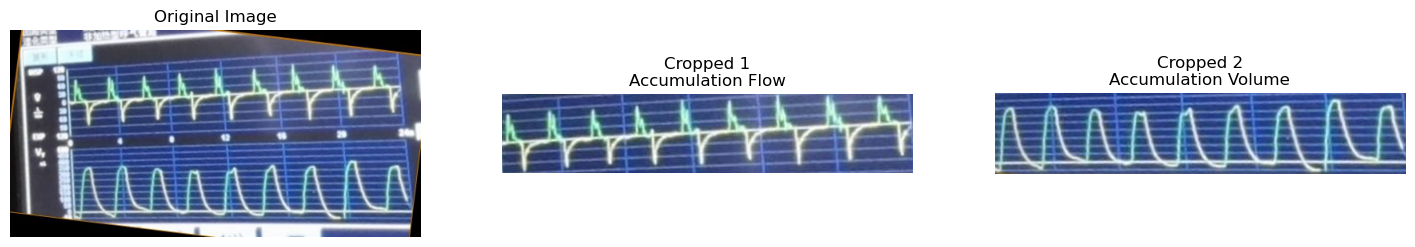

In [45]:
import matplotlib.pyplot as plt

def show_before_after(df, cropped_df, index=0):
    original_path = df.iloc[index]["image_path"]
    original_img = Image.open(original_path)
    base_name = df.iloc[index]["image_name"].split(".")[0]

    samples = cropped_df[cropped_df["image_name"].str.contains(base_name)]

    fig, ax = plt.subplots(1, len(samples)+1, figsize=(6*(len(samples)+1), 6))

    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    for i, (_, row) in enumerate(samples.iterrows(), start=1):
        crop_img = Image.open(os.path.join(SAVE_DIR, row["image_name"]))
        ax[i].imshow(crop_img)
        ax[i].set_title(f"Cropped {i}\n{row['label_name']}")
        ax[i].axis("off")

    plt.show()

show_before_after(df, cropped_df, index=0)


In [46]:
cropped_df.head(6)

,image_name,label_name,label_id
0,000000_Accumulation_Flow_0.jpg,Accumulation Flow,0
1,000000_Volume_1.jpg,Accumulation Volume,1
2,000001_Accumulation_Flow_0.jpg,Accumulation Flow,0
3,000001_Volume_1.jpg,Accumulation Volume,1
4,000002_Accumulation_Flow_0.jpg,Accumulation Flow,0
5,000002_Volume_1.jpg,Accumulation Volume,1


In [47]:
from sklearn.model_selection import train_test_split

print("Total samples after cropping & labeling:", len(cropped_df))

train_df, temp_df = train_test_split(
    cropped_df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=cropped_df['label_id']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['label_id']
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("\nTrain label counts:\n", train_df['label_id'].value_counts().sort_index())
print("\nVal label counts:\n",   val_df['label_id'].value_counts().sort_index())
print("\nTest label counts:\n",  test_df['label_id'].value_counts().sort_index())


Total samples after cropping & labeling: 5814
Train: 4069 Val: 872 Test: 873

Train label counts:
 label_id
0     393
1     393
2     295
3     297
4     307
5     307
6     316
7     316
8     395
9     395
10    333
11    322
Name: count, dtype: int64

Val label counts:
 label_id
0     84
1     84
2     64
3     64
4     66
5     66
6     68
7     68
8     84
9     84
10    71
11    69
Name: count, dtype: int64

Test label counts:
 label_id
0     85
1     85
2     63
3     63
4     65
5     65
6     68
7     68
8     85
9     85
10    72
11    69
Name: count, dtype: int64


In [49]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.RandomRotation(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])


In [50]:
class TanafsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join("newDataset_images", row['image_name'])
        label    = row['label_id']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [51]:
BATCH_SIZE = 16

train_dataset = TanafsDataset(train_df, transform=train_transform)
val_dataset   = TanafsDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First 5 labels: tensor([7, 8, 4, 2, 7])


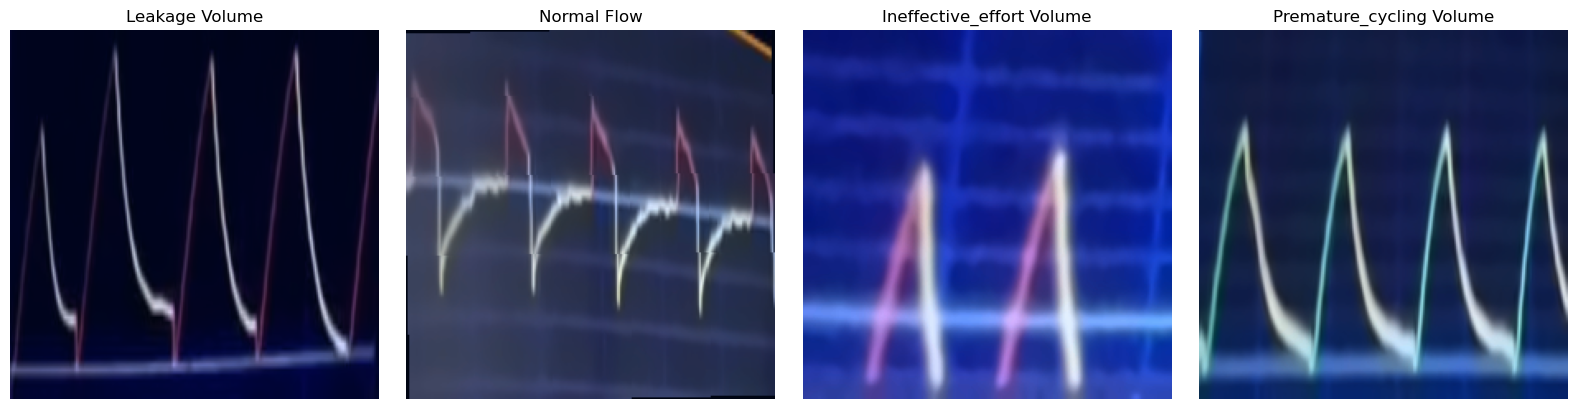

In [52]:
def show_batch(images, labels, classes, n=4):
    imgs = images[:n].clone().detach()
    imgs = imgs.permute(0, 2, 3, 1)  # [B,H,W,3]

    plt.figure(figsize=(4 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i].numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        ax.imshow(img)
        cls_id = int(labels[i].item())
        cls_name = classes[cls_id]
        ax.set_title(cls_name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, CLASSES, n=4)


# **ResNet training (CNN)**

1) Dataset Class

In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WaveformDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join("newDataset_images", row['image_name'])
        label    = row['label_id']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


 2) DataLoaders

In [60]:
BATCH_SIZE = 16

train_dataset = WaveformDataset(train_df, transform=train_transform)
val_dataset   = WaveformDataset(val_df,   transform=val_test_transform)
test_dataset  = WaveformDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("Loaders ready.")


Loaders ready.


3) Load ResNet18 pretrained

In [61]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(cropped_df['label_id'].unique())

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# تعديل آخر طبقة
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Model loaded on:", device)


Model loaded on: cpu


 4) Loss + Optimizer + Class Weights

In [62]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


5) Training Loop

In [63]:
EPOCHS = 15

best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18.pth")
        print("Saved new BEST model!")

print("Training Complete.")


Epoch 1/15 | Train Loss: 0.8513, Train Acc: 0.7329 | Val Loss: 0.3684, Val Acc: 0.8933
Saved new BEST model!
Epoch 2/15 | Train Loss: 0.3153, Train Acc: 0.9017 | Val Loss: 0.2931, Val Acc: 0.9083
Saved new BEST model!
Epoch 3/15 | Train Loss: 0.1896, Train Acc: 0.9472 | Val Loss: 0.2542, Val Acc: 0.9220
Saved new BEST model!
Epoch 4/15 | Train Loss: 0.1262, Train Acc: 0.9641 | Val Loss: 0.2923, Val Acc: 0.9083
Epoch 5/15 | Train Loss: 0.0977, Train Acc: 0.9698 | Val Loss: 0.2479, Val Acc: 0.9266
Saved new BEST model!
Epoch 6/15 | Train Loss: 0.1001, Train Acc: 0.9700 | Val Loss: 0.2348, Val Acc: 0.9312
Saved new BEST model!
Epoch 7/15 | Train Loss: 0.0516, Train Acc: 0.9850 | Val Loss: 0.2197, Val Acc: 0.9495
Saved new BEST model!
Epoch 8/15 | Train Loss: 0.0407, Train Acc: 0.9899 | Val Loss: 0.2510, Val Acc: 0.9266
Epoch 9/15 | Train Loss: 0.0740, Train Acc: 0.9779 | Val Loss: 0.2156, Val Acc: 0.9415
Epoch 10/15 | Train Loss: 0.0512, Train Acc: 0.9850 | Val Loss: 0.2209, Val Acc: 0.94

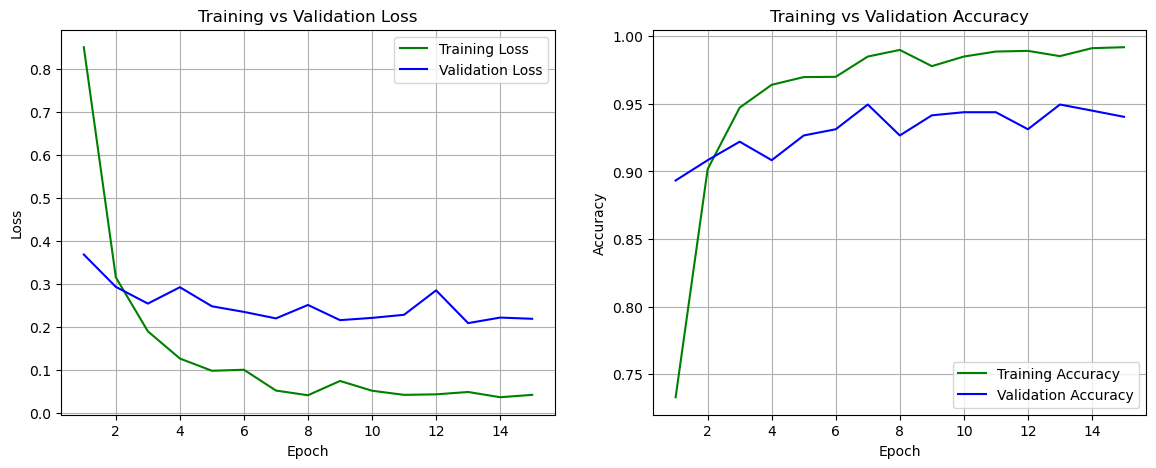

In [64]:
train_losses = [
    0.8513,0.3153,0.1896,0.1262,0.0977,
    0.1001,0.0516,0.0407,0.0740,0.0512,
    0.0416,0.0428,0.0483,0.0361,0.0416
]

val_losses = [
    0.3684,0.2931,0.2542,0.2923,0.2479,
    0.2348,0.2197,0.2510,0.2156,0.2209,
    0.2281,0.2850,0.2087,0.2216,0.2188
]

train_accuracies = [
    0.7329,0.9017,0.9472,0.9641,0.9698,
    0.9700,0.9850,0.9899,0.9779,0.9850,
    0.9887,0.9892,0.9853,0.9912,0.9919
]

val_accuracies = [
    0.8933,0.9083,0.9220,0.9083,0.9266,
    0.9312,0.9495,0.9266,0.9415,0.9438,
    0.9438,0.9312,0.9495,0.9450,0.9404
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


6) Evaluation on Test Set (Accuracy + F1 + Confusion Matrix)

In [65]:
import torch
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# تحميل أفضل أوزان للموديل
best_model = model  # نستخدم نفس الموديل اللي دربناه
state_dict = torch.load("best_resnet18.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

# تقييم على test_loader باستخدام نفس evaluate اللي عندك
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2723
Test Accuracy: 0.9347



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        85
           1       0.81      0.99      0.89        85
           2       1.00      0.98      0.99        63
           3       0.98      0.92      0.95        63
           4       0.98      0.97      0.98        65
           5       0.88      0.88      0.88        65
           6       0.89      0.99      0.94        68
           7       0.94      1.00      0.97        68
           8       0.99      0.91      0.94        85
           9       0.97      0.89      0.93        85
          10       0.99      0.97      0.98        72
          11       0.91      0.77      0.83        69

    accuracy                           0.93       873
   macro avg       0.94      0.93      0.94       873
weighted avg       0.94      0.93      0.93       873



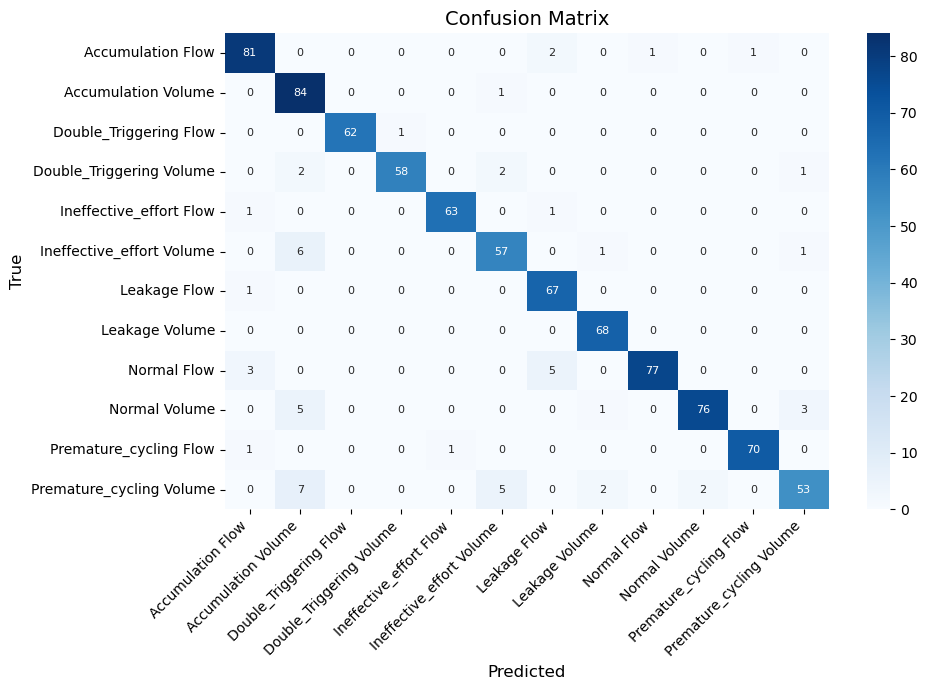

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_resnet18.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap="Blues",     
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}  
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4671633..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..0.9319392].


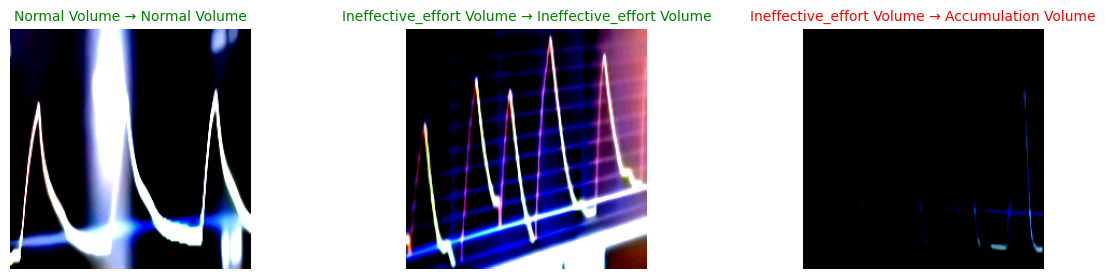

In [67]:
# %%
def show_predictions_grid(model, loader, class_names, device, num_images=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                # لو فيه Normalization ممكن تحتاجين ترجعينه [0,1] أو [0,255] حسب البريبروسيس

                label = labels[i].item()
                pred = preds[i].item()

                true_name = class_names[label]
                pred_name = class_names[pred]

                ax = plt.subplot(3, 4, images_shown + 1)
                ax.imshow(img)
                ax.axis("off")

                title = f"{true_name} → {pred_name}"
                color = "green" if label == pred else "red"
                ax.set_title(title, color=color, fontsize=10)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

show_predictions_grid(best_model, test_loader, CLASSES, device, num_images=3)
